In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

In [5]:
from src.vols.constant_vol import *
from src.gans.ivgan import IVGan
from src.networks.ffn import FFNetwork
from src.utils import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
set_plot_params()

In [107]:
N_paths = 10016
total_timesteps = 60*60*7.5 #1 second data
n_timesteps = 60 #train at 1 min interval

vol_model = ConstantVol(sigma=0.2)
spots, vols = vol_model.generate(N_paths, total_timesteps, n_timesteps, reshape_for_rnn=True)

First train a model using a method of moments. We try to match the first $k$ moments of the distribution generated by 
$$
Z_F = \frac{X_1 - X_0}{\sqrt{F(X_0,X_{1/n},X_{2/n},\ldots,X_{(n-1)/n},X_1)}}
$$
to those of the standard normal. We set $k=4$ and train using the $L1$ norm. We use a simple feedforward neural network, and train for 10 epochs.

In [104]:
generator = FFNetwork(n_layers=2, h_dims=32, loss=None, lr=0.00000001)
discriminator = FFNetwork(n_layers=2, h_dims=32, loss=None, lr=0.000002)

In [105]:
gan = IVGan(discriminator, generator)

In [108]:
result = gan.train(x_train=spots.squeeze(-1),
        true_sample=np.random.normal(size=(N_paths, 1)),
        num_epochs=10,
        batch_size=256,
        clip=True,
        num_critic=10,
)


If you intended to run this layer in float64, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float32 by default, call `tf.keras.backend.set_floatx('float32')`. To change just this layer, pass dtype='float32' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




InvalidArgumentError: Index out of range using input dim 2; input has only 2 dims [Op:StridedSlice] name: strided_slice/

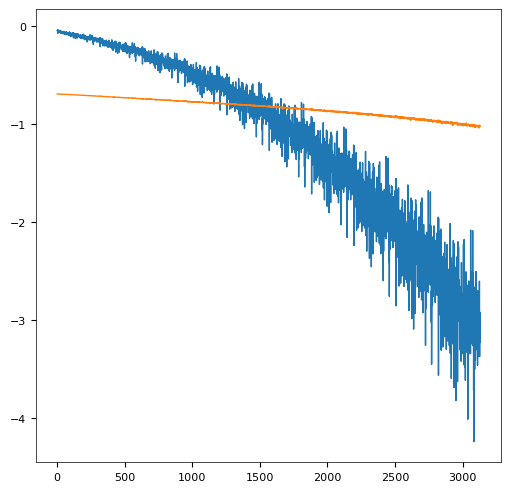

In [96]:
plt.plot(result['critic_loss'])
plt.plot(result['generator_loss'])

In [101]:
spots, vols = vol_model.generate(10000, total_timesteps, n_timesteps)
iv = generator.predict_iv(spots)
true_iv = np.sum(vols**2/total_timesteps, axis=1)

In [102]:
iv

array([0.19959241, 0.2016928 , 0.2010459 , ..., 0.20073594, 0.19977746,
       0.20030891])

In [103]:
true_iv

array([8.888888e-05, 8.888888e-05, 8.888888e-05, ..., 8.888888e-05,
       8.888888e-05, 8.888888e-05], dtype=float32)

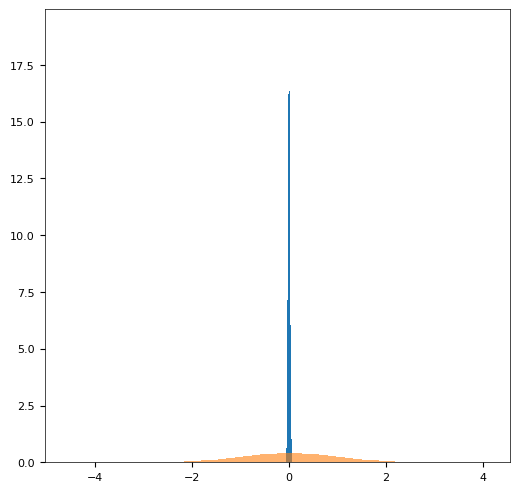

In [100]:
plt.hist((spots[:,-1] - spots[:,0])/np.sqrt(iv), bins=50, density=True)
#plt.hist((spots[:,-1] - spots[:,0])/np.sqrt(np.squeeze(true_iv)), bins=50, density=True)

plt.hist(np.random.normal(size=100000), bins=50, alpha=0.6, density=True)
plt.show()

In [188]:
z = (spots[:,-1,0] - spots[:,0,0])/np.sqrt(np.squeeze(true_ivs))

In [190]:
RBFMMDLoss()(spots[:,-1,0] - spots[:,0,0], np.squeeze(true_ivs))

<tf.Tensor: shape=(), dtype=float64, numpy=0.0003705099211863683>

In [191]:
RBFMMDLoss()(spots[:,-1,0] - spots[:,0,0], iv)

<tf.Tensor: shape=(), dtype=float64, numpy=-1.6726540690958913e-05>

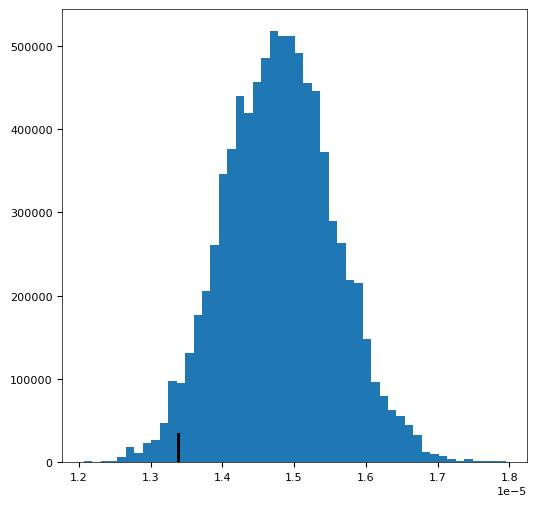

In [171]:
plt.hist(true_ivs, bins=50, density=True)
plt.vlines(iv, ymin=0, ymax=35000.0)
plt.show()

In [181]:
np.mean(true_ivs)

1.4802211489946724e-05